In [2]:
from __future__ import print_function
import sys
import os
import logging
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics
%config Completer.use_jedi = False
import SimpleITK as sitk
import nibabel as nib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import logging
import cv2
import scipy.ndimage as nd
from utils import get_all_good_slices, give_ls, get_good_slice, rescale_image, rescale_image_float
from utils_mask_sain import compute_score, compute_standard

In [3]:
path_data_brut = "../data/radio_brut"
current_dir = os.getcwd()
if current_dir == "/gpfs/users/selvestra/python_codes":
    path_data_brut = "/gpfs/workdir/selvestra/data/radio_brut"
path_radios = './*_NAT*/*.nii'
path_brut = os.path.join(path_data_brut, path_radios)
path_data = os.path.dirname(path_data_brut)
path_save = os.path.join(
    path_data, "multislice_excel_with_shape_2D_entre_deux.xlsx")
ls_image = sorted(glob.glob(path_brut))
mask_superpose = give_ls(ls_image)
#print(ls_image[0])

./Dataset_CCK_NAT/10_ART.nii


Tumeurs difficiles:
0,8,32,140, 200, 270,273, 360
Chercher la plus grande composante connexe. Pénaliser la distance vs centre? (pour pénaliser le second cercle!)

### Lire une image et afficher sa bonne slice

In [4]:
def slice_show(image_num):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    print(image.GetSize())
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    print(mask.GetSize())
    n_slices = image.GetSize()[2]
    li_good = []
    for slice_num in range(n_slices):
        slice_try = image[:,:,slice_num]
        mask_slice_try = mask[:,:,slice_num]
        lsif = sitk.LabelStatisticsImageFilter()
        lsif.Execute(slice_try, mask_slice_try != 0)
        boundingBox = np.array(lsif.GetBoundingBox(label = 1))
        ndims = np.sum((boundingBox[1::2] - boundingBox[0::2] + 1) > 3)  # UBound - LBound + 1 = Size
        if (sitk.GetArrayFromImage(mask_slice_try != 0).sum() > 0) & (ndims >= 2):
            li_good.append(slice_num)
    if len(li_good) == 0:
        print('No good slices')
        return
    correct_slice = li_good[len(li_good)//2]
    slice_good = image[:,:,correct_slice]
    plt.figure(figsize = (15,5))
    plt.subplot(1, 2, 1)
    plt.imshow(sitk.GetArrayFromImage(slice_good))
    mask_slice_good = mask[:,:,correct_slice]
    plt.subplot(1, 2, 2)
    plt.imshow(sitk.GetArrayFromImage(mask_slice_good))
    print("slice_num:", correct_slice)

(512, 512, 100)
(512, 512, 100)
slice_num: 65


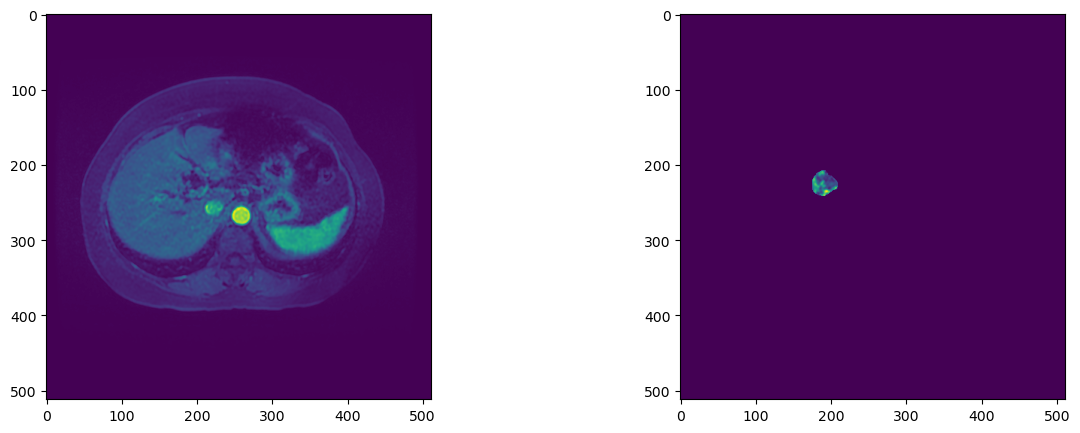

In [5]:
slice_show(4)

### Lire une image et afficher le mask par dessus

On peut même afficher un second masque en plus!

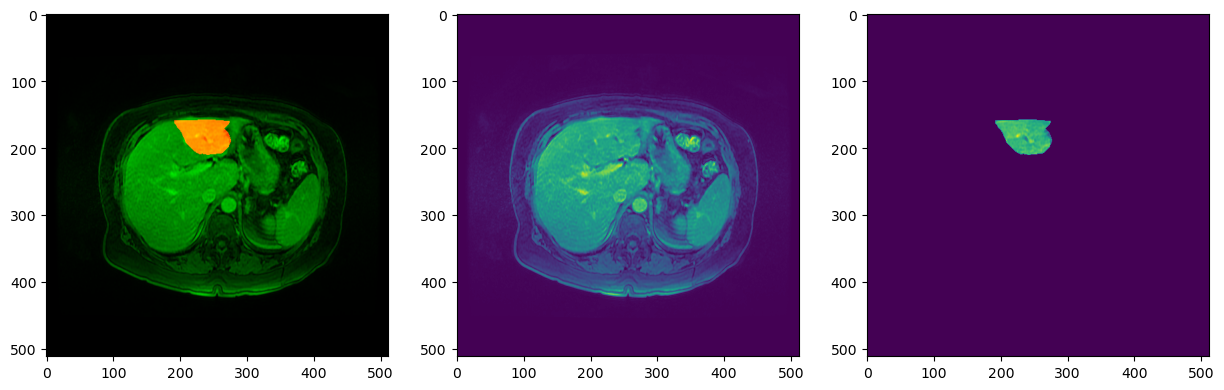

In [6]:
mask_superpose(25)

### Dilatation et érosion d'une image avec opencv

In [7]:
def cercle_image(image_num, slice_num = None,show = False):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii')
    mask = sitk.ReadImage(name_mask)
    if slice_num is None:
        slice_num = get_good_slice(image_name)
    slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
    mask_slice_good = sitk.GetArrayFromImage(mask[:,:,slice_num]) !=0
    mask_slice_good = mask_slice_good.astype(np.uint8)
    mask_dilation_first = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 5) #10 et 18
    mask_dilation_second = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 15)
    # mask_dilation_3 = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 40)
    # mask_dilation_4 = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 50)
    mask_cercle = mask_dilation_second - mask_dilation_first # + mask_dilation_4 - mask_dilation_3
    
    #histogramme sur variance locale
    
    filtered = rescale_image_float(slice_good).astype(np.float64)
    size = 5
    mean = nd.uniform_filter(filtered, size)
    mean_sq = nd.uniform_filter(filtered**2, size)
    variance = (mean_sq - mean**2)
    #hist, bins = np.histogram(variance[mask_cercle == 1].flatten(), bins = "doane")
    hist, bins = np.histogram(variance[mask_cercle == 1].flatten(), bins = 100)
    #On a les bins maintenant on classe les points
    shape_init = slice_good.shape
    bin_indices = np.digitize(variance.flatten(), bins) - 1
    bin_indices = bin_indices.reshape(shape_init)
    bin_indices[mask_cercle == 0] = -1
    
    #On choisit les bins qu'on garde de l'histogramme: à côté les unes des autres
    pic = np.argmax(hist)
    pic = 0 ##################### ATTENTION C'est car on cherche le minimum de variance
    deja_pris = [pic]
    taille_max = np.sum(mask_cercle == 1)*0.2
    taille = hist[pic]
    nbins = len(hist)
    while taille < taille_max:
        possible = []
        if max(deja_pris) + 1< nbins :
            possible.append(max(deja_pris) + 1)
        if min(deja_pris) > 0:
            possible.append(min(deja_pris) - 1)
        values = [hist[i] for i in possible]
        new_bar = possible[np.argmax(values)]
        deja_pris.append(new_bar)
        taille = taille + hist[new_bar]
    
    bool_matrix = np.isin(bin_indices, deja_pris)
    
    quantile_low_lum =0.5* np.quantile(slice_good.flatten(),0.9)+ 0.5 *np.min(slice_good.flatten()) #pas être dans le noir complet
    cercle_lumineux = bool_matrix & (slice_good > quantile_low_lum)
    
    
    # quantile_inf_cercle = np.quantile(slice_good[mask_cercle == 1].flatten(),0.5)
    # quantile_sup_tumeur = np.quantile(slice_good[mask_slice_good == 1].flatten(),0.7)
    # if quantile_inf_cercle < np.quantile(slice_good[mask_slice_good == 1].flatten(),0.3):
    #     cercle_lumineux = (slice_good > quantile_inf_cercle) & (mask_cercle == 1) & (slice_good < quantile_sup_tumeur)
        
    # else:
    #     cercle_lumineux = (mask_cercle == 1) & (slice_good > quantile_inf_cercle)
    cercle_lumineux = cercle_lumineux.astype(np.uint8)
    if show:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(bool_matrix)
        plt.subplot(1, 3, 2)
        plt.imshow(variance)
        plt.subplot(1, 3, 3)
        plt.hist(variance[mask_cercle == 1].flatten(), bins=bins, edgecolor='black')
        plt.title("Histogramme des valeurs des pixels")
        plt.xlabel("Valeur des pixels")
        plt.ylabel("Fréquence")
        plt.show()
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle)
        mask_superpose(image_num, slice_num = slice_num, other_mask = cercle_lumineux)
    return cercle_lumineux, slice_good, mask_slice_good, mask_cercle
    


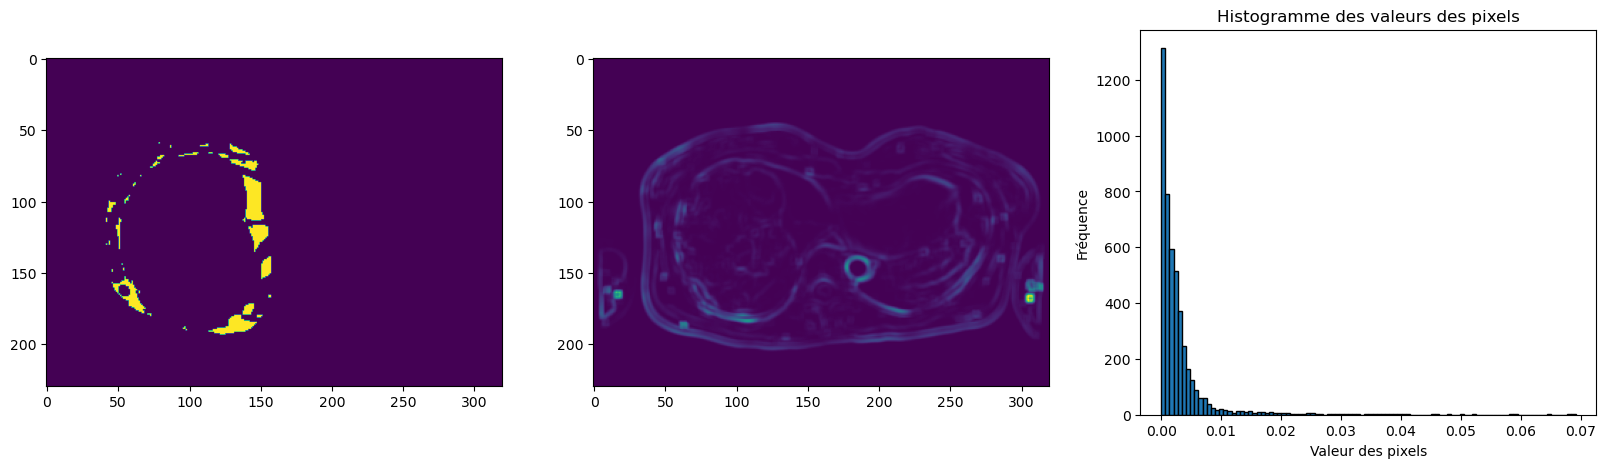

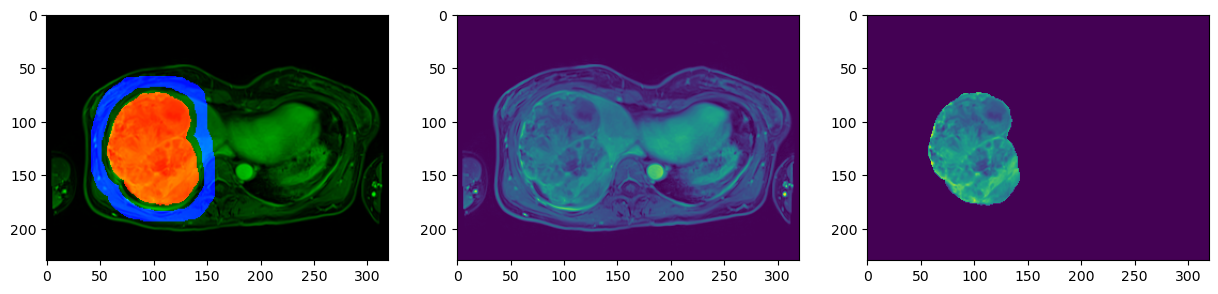

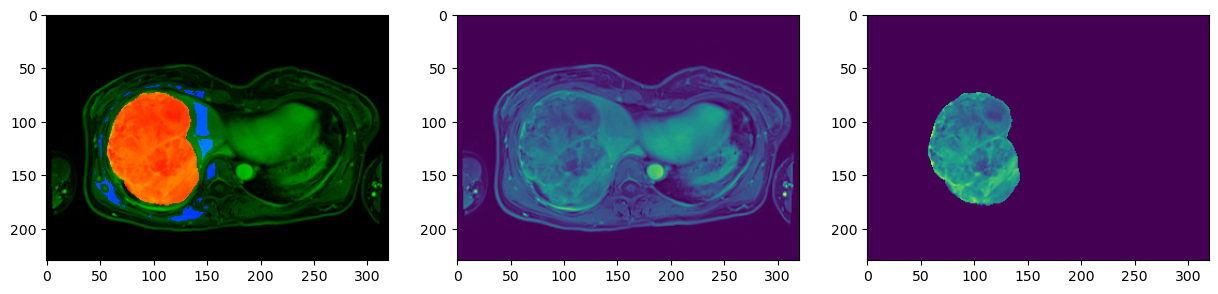

In [8]:
li = cercle_image(140, show = True)


### Avec des composantes connexes

Double critère avec la proximité vs la luminosité de la tumeur

In [9]:
def cercle_image_compos_connexe(image_num, slice_num = None,show = False):
    if slice_num is None:
        slice_num = get_good_slice(ls_image[image_num])
    mask_cercle_lumineux, slice_good, mask_slice_good, mask_cercle = cercle_image(image_num, slice_num= slice_num,show = False)
    components, num_comp = nd.label(mask_cercle_lumineux) #l'indexation des composantes commence à 1
    intens_standard = compute_standard(components, num_comp, slice_good, mask_slice_good)
    dict_sizes = {str(i) : compute_score(i,components, slice_good, mask_slice_good ,mask_cercle_lumineux, intens_standard) for i in range(1, num_comp + 1)}
    dict_sizes = dict(sorted(dict_sizes.items(), key=lambda item: item[1], reverse = True))
    size_to_cover  = min(np.sum(mask_cercle) * 0.05, np.sum(mask_cercle_lumineux) * 0.5)
    covered_size = 0
    li_keys_compos_connexe = []
    i = 0
    while covered_size < size_to_cover:
        key = list(dict_sizes.keys())[i]
        li_keys_compos_connexe.append(key)
        covered_size += np.sum(components == int(key))
        i += 1
    if(len(li_keys_compos_connexe) >0):
        li_keys_compos_connexe = [li_keys_compos_connexe[0]]
    else:
        print("echec mask vide image", image_num, "slice",slice_num)
        return np.zeros_like(mask_cercle_lumineux)
    mask_cercle_compos_connexe = np.zeros_like(mask_cercle_lumineux)
    for key in li_keys_compos_connexe:
        mask_cercle_compos_connexe += (components == int(key)).astype(np.uint8)
    if show:
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle_lumineux)
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle_compos_connexe)
    return mask_cercle_compos_connexe
    
        
    


In [10]:
li = cercle_image_compos_connexe(445,show = True, slice_num= 82)
#li = cercle_image_compos_connexe(4,show = True)

echec mask vide image 445 slice 82


In [11]:
def test_filtre():
    image_num = 8
    size = 5

    slice_num = get_good_slice(ls_image[image_num])
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii')
    mask = sitk.ReadImage(name_mask)
    slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
    filtered = rescale_image_float(slice_good).astype(np.float32)

    mean = nd.uniform_filter(filtered, size)
    mean_sq = nd.uniform_filter(filtered**2, size)
    variance = (mean_sq - mean**2)
    #variance = nd.uniform_filter((filtered - mean)**2, size)
    print(np.quantile(variance,0.95))
    plt.figure(figsize = (15,5))
    plt.subplot(1, 2, 1)
    plt.imshow(variance)
    plt.subplot(1, 2, 2)
    plt.imshow(filtered)

### Généralisation

In [12]:
def extract_all():
    for i, image_name in tqdm.tqdm(enumerate(ls_image)):
        good_slices  = get_all_good_slices(image_name)
        for slice_num in good_slices:
            #print(good_slices)
            mask_sain = cercle_image_compos_connexe(i,slice_num)
            nom = image_name.replace('_NAT','_sain').replace('.nii',f'_masked_sain_slice_{slice_num}.npy') 
            np.save(nom, mask_sain)
            
            
            
        

In [13]:
#extract_all()

58


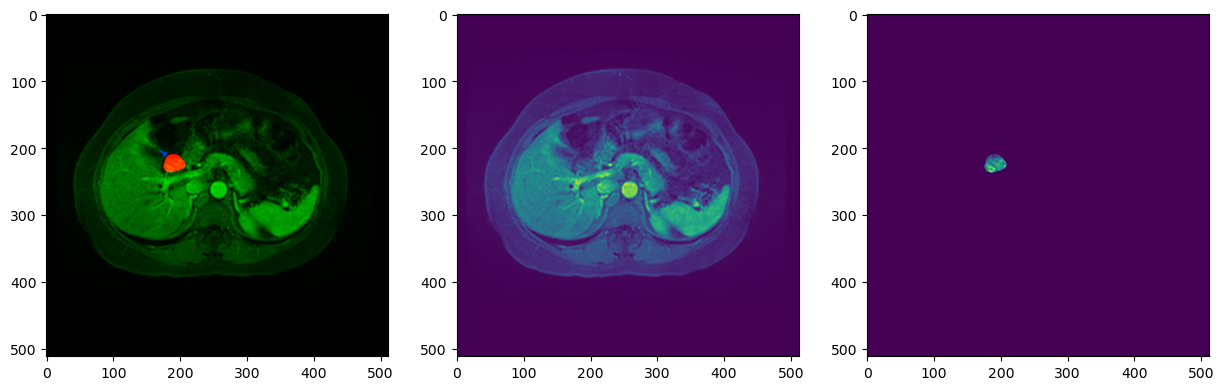

In [14]:
image_name = ls_image[5]
mask_sain_name_incomplet = image_name.replace('_NAT','_sain').replace('.nii',f'_masked_sain_slice_') 
ls_mask_sain_for_image_i = sorted(glob.glob(mask_sain_name_incomplet + '*'))
mask_sain_name = ls_mask_sain_for_image_i[0]
slice_num = int(mask_sain_name.split('_')[-1].replace('.npy',''))
mask_sain = np.load(mask_sain_name)
mask_superpose(5, slice_num = slice_num, other_mask = mask_sain)
print(slice_num)

